In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import pickle
import seaborn as sns
from pandas import Timestamp
import gpflow
from gpflow.utilities import print_summary
from gpflow import set_trainable
import tensorflow as tf
from sklearn.metrics import mean_squared_error
from math import sqrt
from datetime import timedelta
from gpflow.config import default_float
import math

In [2]:
def read_pickle(filepath):
    d = pickle.load(open(filepath,'rb'))
    X = d['X']
    Y = d['Y']
    keep = ~np.isnan(Y[:,0]) #remove nans from data...
    Yset = Y[keep,:]
    Xset = X[keep,:]
    return X, Y, Xset, Yset

In [3]:
X, Y, Xset, Yset = read_pickle('kampala_with_distance_population_24_09_20.p')

In [4]:
X[0, :] 

array([3.2610756e+01, 3.6020900e-01, 1.7460000e+01, 4.6370800e+03,
       4.4454400e+05])

In [5]:
#X training dataset with long, lat and time
Xset_basic = np.delete(Xset, [2, 3], 1)
Xset_basic[0, :]

array([3.2610756e+01, 3.6020900e-01, 4.4454400e+05])

In [6]:
basic_kernel = gpflow.kernels.RBF(lengthscales=[0.08, 0.08, 1.]) + gpflow.kernels.Bias()

In [7]:
f = lambda time: Timestamp.fromtimestamp(time*3600)
f2 = np.vectorize(f)

In [8]:
longs = [X[:,0][index] for index in sorted(np.unique(X[:,0], return_index=True)[1])]
lats = [X[:,1][index] for index in sorted(np.unique(X[:,1], return_index=True)[1])]

In [9]:
def cross_validation(X, Y, long, lat, kern):
    '''
    Performs cross validation by removing a specific location's data from the dataset
    '''    
    location_indices = np.where(np.logical_and(X[:,0]==long, X[:,1]==lat))
    try:
        Xset = X[np.logical_not(np.logical_and(X[:,0]==long, X[:,1]==lat))]
        Yset = np.delete(Y, slice(location_indices[0][0],location_indices[0][-1]+1), axis=0)
        
        Xtraining = Xset[::2,:]
        Ytraining = Yset[::2,:]
    
        Xtest = X[np.logical_and(X[:,0]==long, X[:,1]==lat)]
        Ytest = Y[location_indices[0][0]:location_indices[0][-1]+1]
    
        m = gpflow.models.GPR(data=(Xtraining, Ytraining), kernel=kern, mean_function=None)
        set_trainable(m.kernel.kernels[0].lengthscales, False) 
    
        opt = gpflow.optimizers.Scipy()

        def objective_closure():
             return - m.log_marginal_likelihood()

        opt_logs = opt.minimize(objective_closure, m.trainable_variables, options=dict(maxiter=100))
    
        mean, var = m.predict_f(Xtest)
    
        return mean.numpy(), var.numpy(), Xtest, Ytest
    except:
        print('An exception occured')

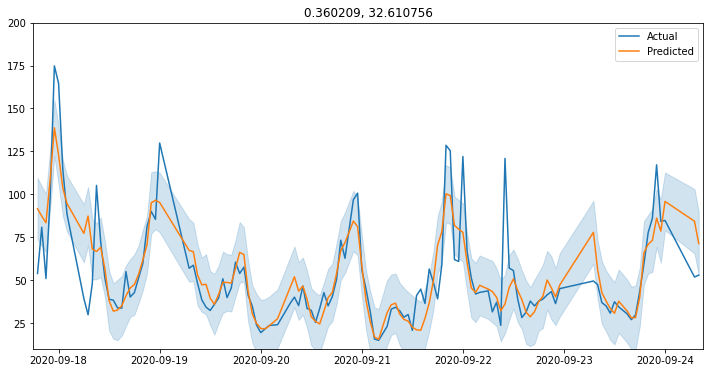

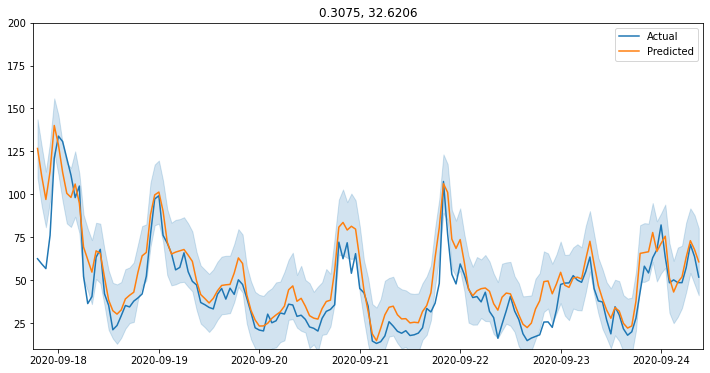

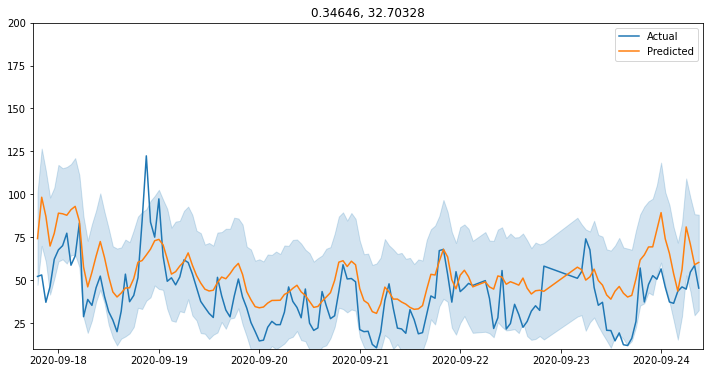

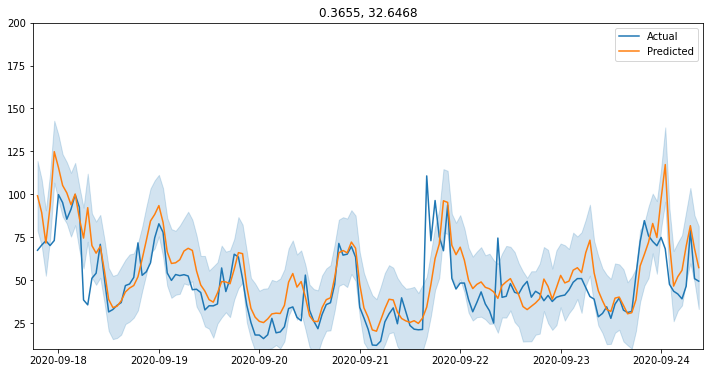

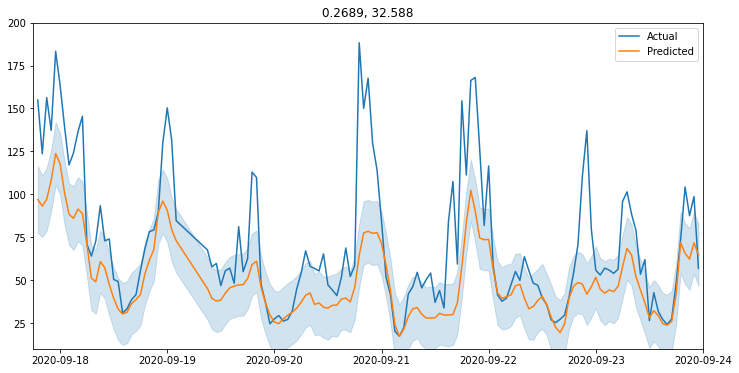

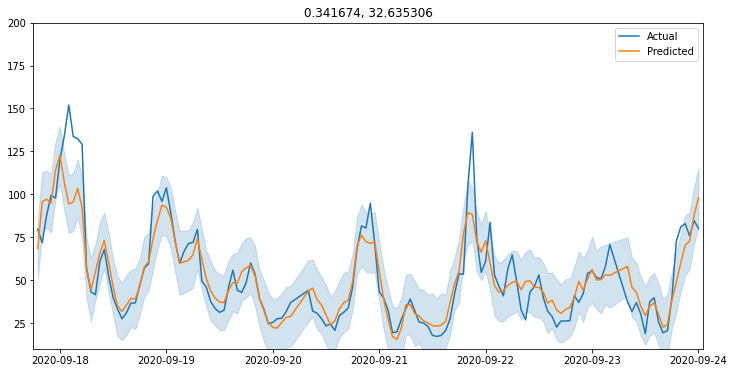

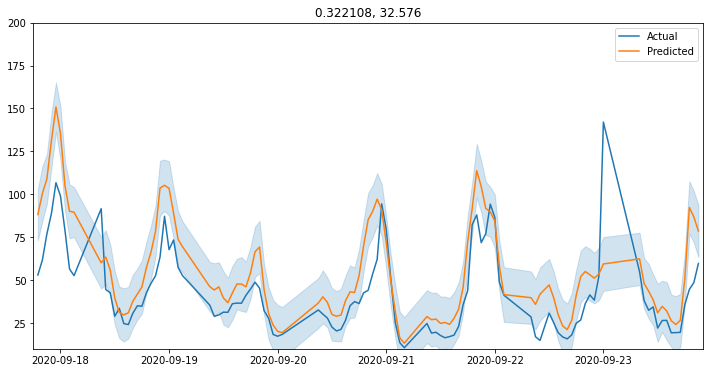

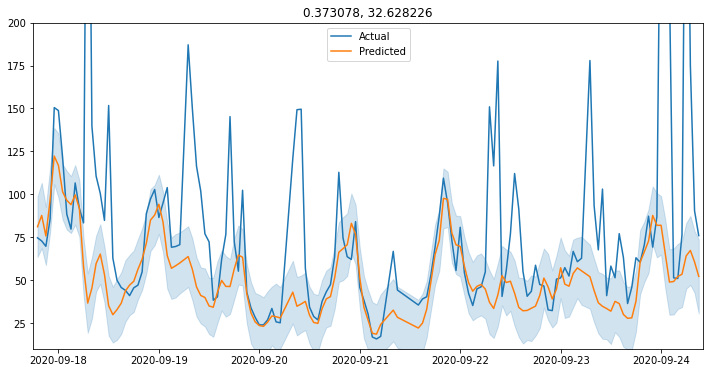

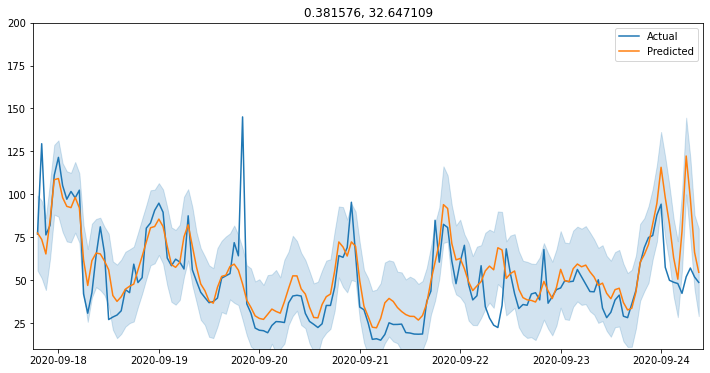

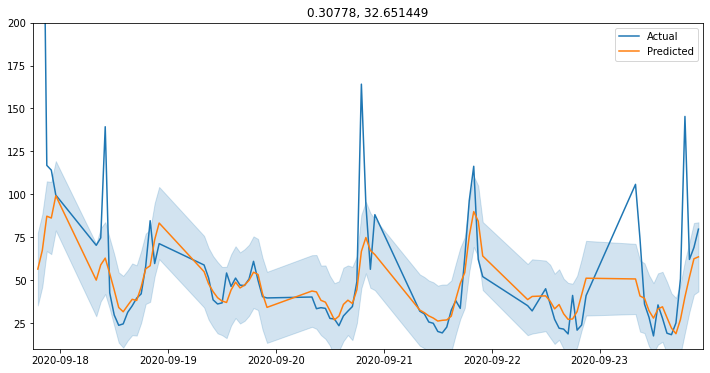

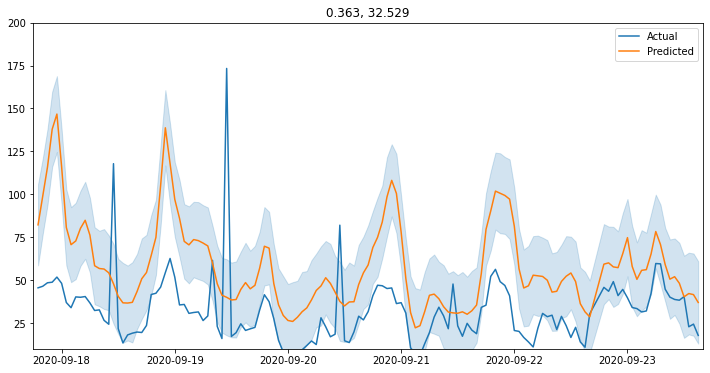

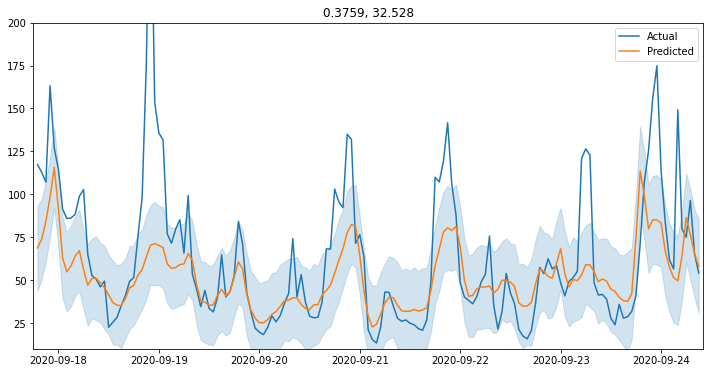

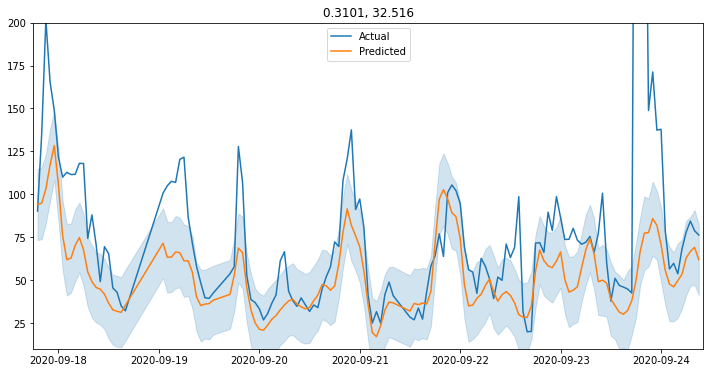

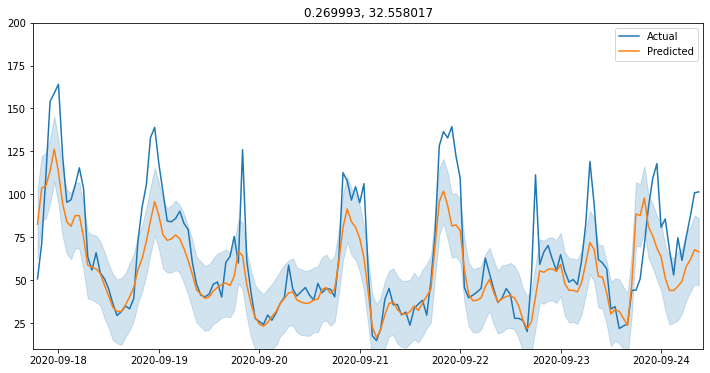

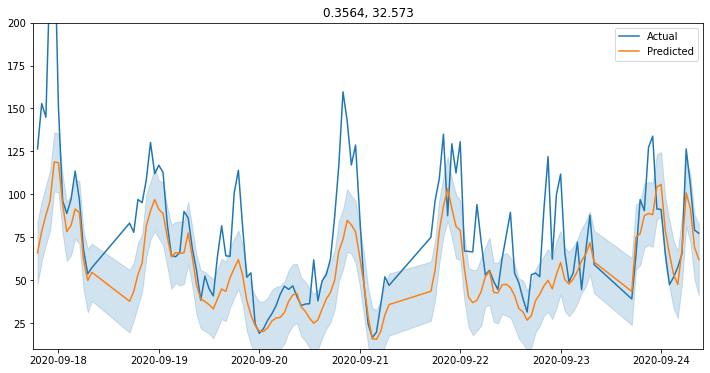

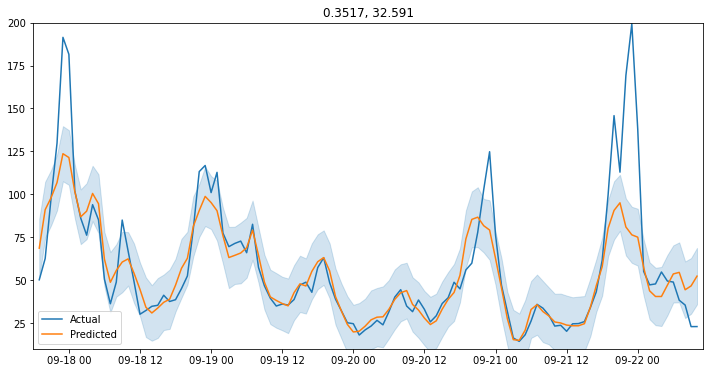

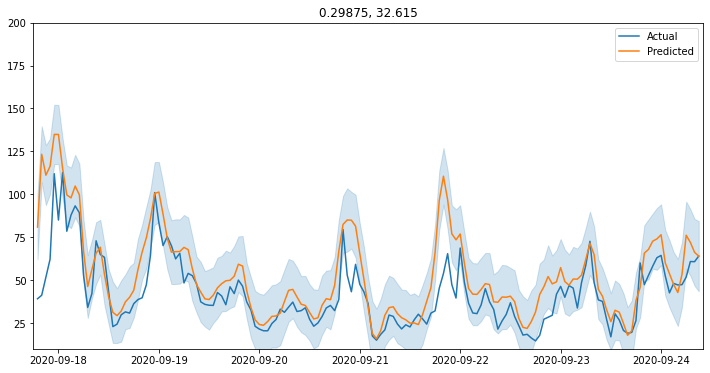

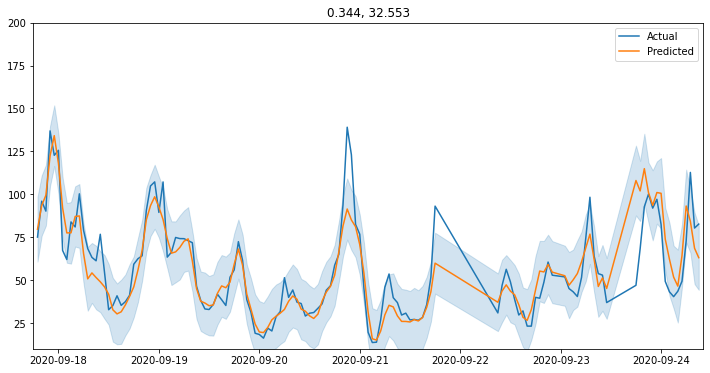

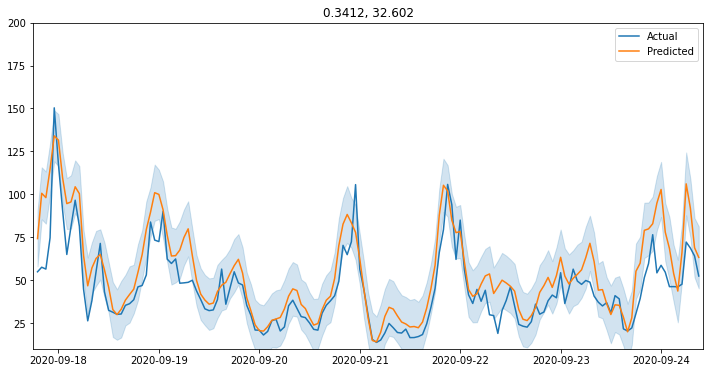

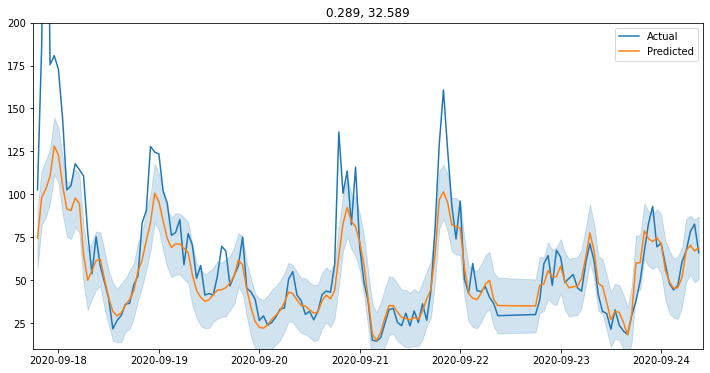

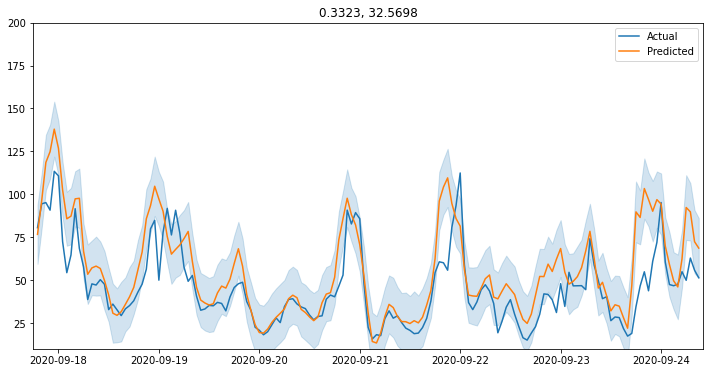

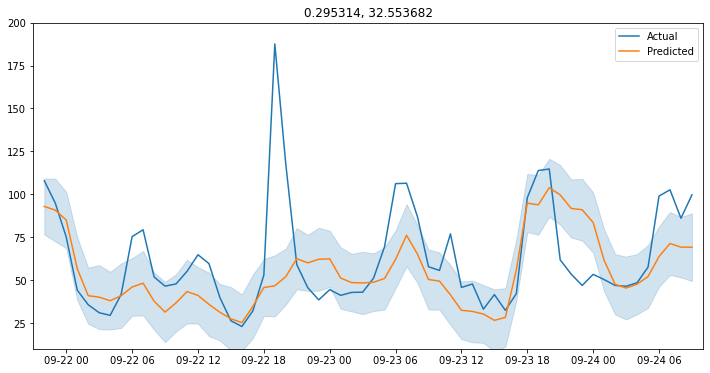

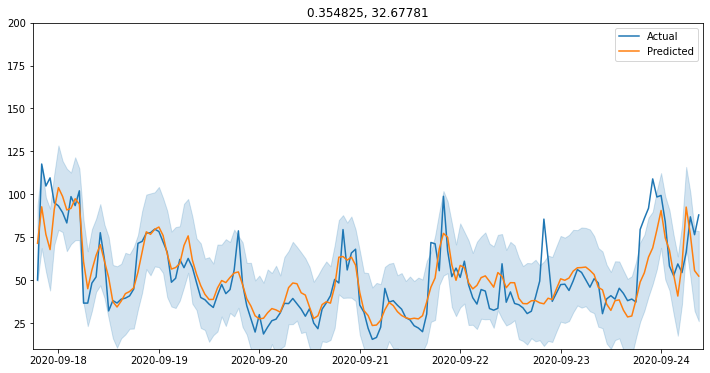

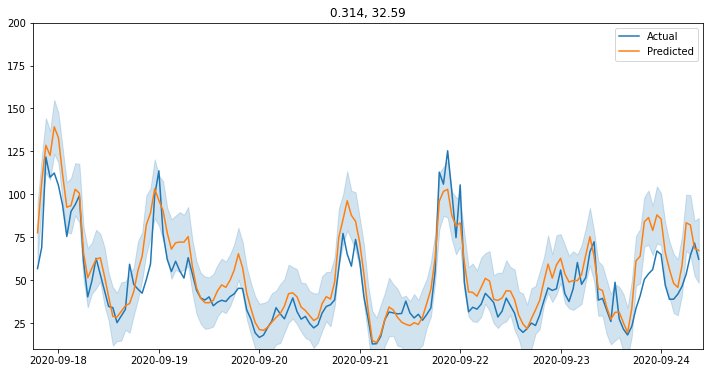

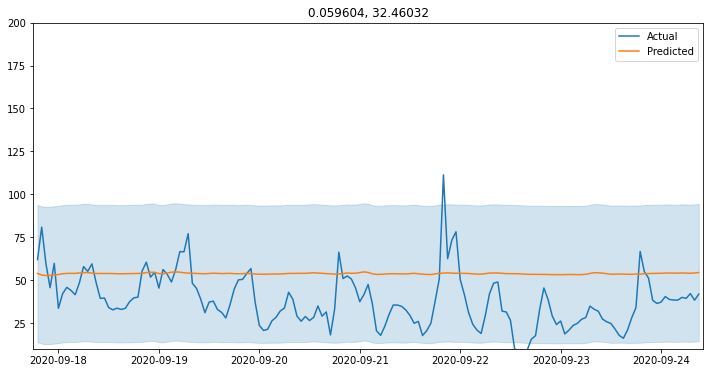

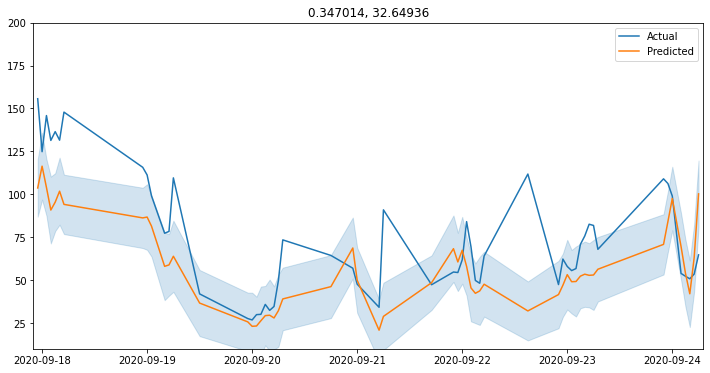

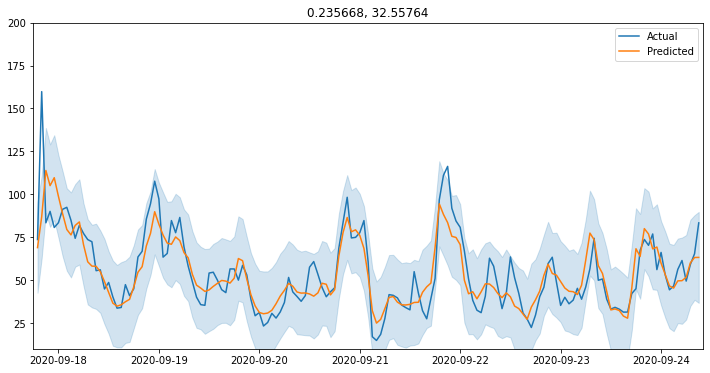

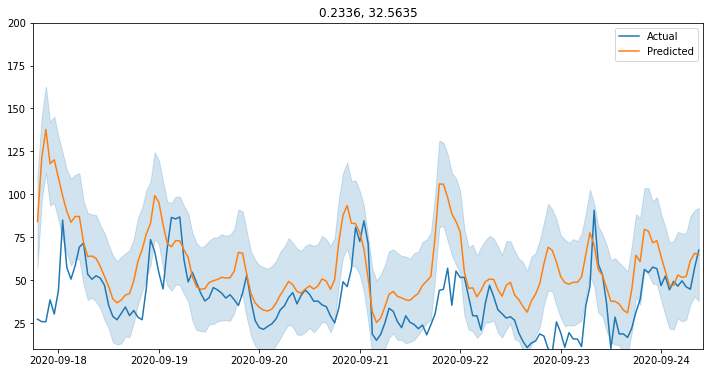

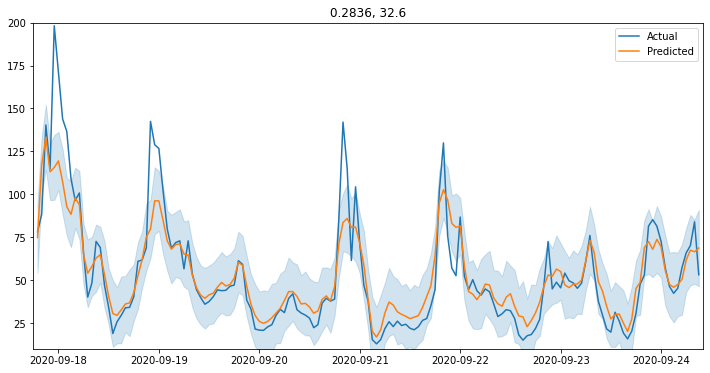

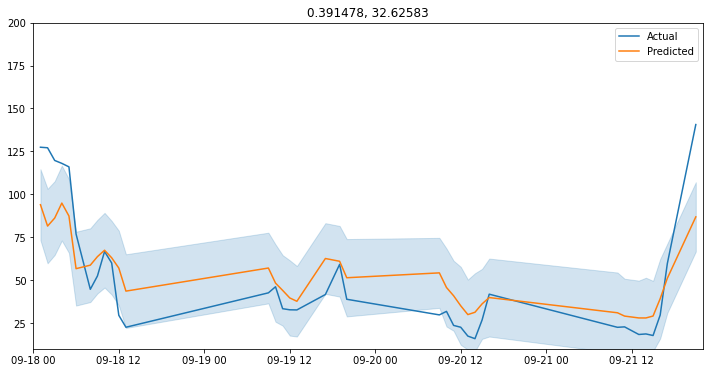

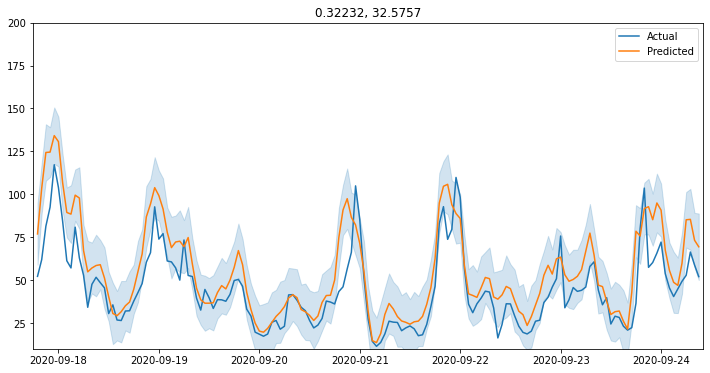

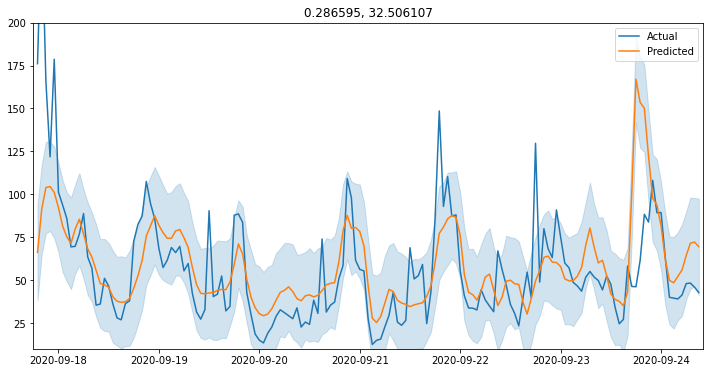

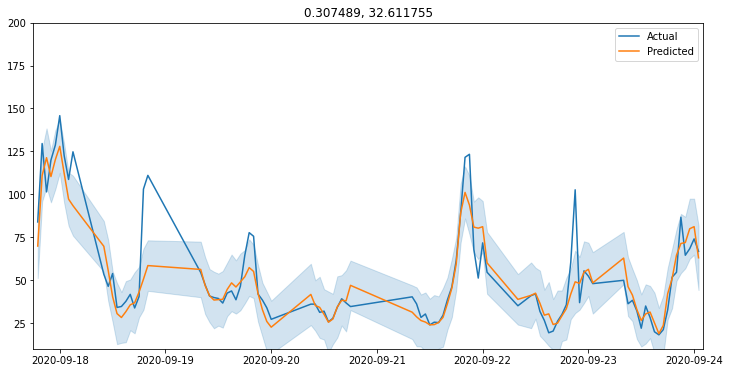

In [22]:
for i in range(len(longs)):
    mean, var, Xtest, Ytest = cross_validation(Xset_basic, Yset, longs[i], lats[i], basic_kernel)
    plt.figure(figsize=(12,6))
    plt.title(f'{lats[i]}, {longs[i]}')
    plt.xlim(f2(Xtest[:,2]).min()-timedelta(hours=1), f2(Xtest[:,2]).max()+timedelta(hours=1))
    plt.ylim(10,200)
    plt.plot(f2(Xtest[:, 2]), Ytest, label='Actual')
    plt.plot(f2(Xtest[:, 2]), mean, label='Predicted')
    plt.fill_between(f2(Xtest[:, 2]),
                    mean[:,0]-1.96*np.sqrt(var[:, 0]),
                    mean[:,0]+1.96*np.sqrt(var[:, 0]),
                    color="C0",
                    alpha=0.2)

    plt.legend(loc='best')
    plt.savefig(f'basic_model_with_error_bars/{i}.png') 
    plt.show()

In [24]:
f2(Xtest[:,2]).max()+timedelta(hours=1)

Timestamp('2020-09-24 02:00:00')

In [25]:
Xtest[0, :]

array([3.2611755e+01, 3.0748900e-01, 4.4454400e+05])

In [27]:
Yset.shape

(4533, 1)